In [1]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from trustee import ClassificationTrustee
from trustee.report.trust import TrustReport

plt.rcParams['font.family'] = 'sans-serif'

In [2]:
# Dataset folders
dataset_list = ['A', 'B1', 'B2', 'C', 'D']
dataset_list = ['A']

current_dir = os.getcwd()
base_path = '' + current_dir + '/test_data'
print(base_path)
# base_path = './test_data'

# Quality labels to predict
quality_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    path_pattern = os.path.join(base_path + dataset, '*.csv')  # <-- match all CSVs
    print(f"Searching in: {path_pattern}")
    for file_path in glob(path_pattern):
        try:
            df = pd.read_csv(file_path, dtype=str)
            # print(f"Loaded {file_path} with shape {df.shape}")
            df['source_dataset'] = dataset  # Optional: keep track of source
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
# # Combine all data

/Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/test_data
Loading CSV files...


Datasets:   0%|          | 0/1 [00:00<?, ?it/s]

Searching in: /Users/stevenjiang/Documents/GitHub/293N-YT-ABR-Prediction/test_dataA/*.csv


Datasets: 100%|██████████| 1/1 [00:34<00:00, 34.34s/it]


In [3]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

Combining CSVs into one DataFrame...
Total rows loaded: 2091480


In [4]:
print(data.columns)

Index(['RelativeTime', 'PacketsSent', 'PacketsReceived', 'BytesSent',
       'BytesReceived', 'IPSrc0', 'IPDst0', 'Protocol0', 'PacketsSent0',
       'PacketsReceived0',
       ...
       'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p', 'BufferHealth',
       'BufferProgress', 'BufferValid', 'source_dataset'],
      dtype='object', length=208)


In [5]:
# Drop rows with missing target values
quality_to_index = {q: i for i, q in enumerate(quality_labels)}

data[quality_labels]

df_numeric = data[quality_labels].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

#data[quality_labels].idxmax(axis=1)

#.map(quality_to_index)

# data['PlaybackQuality'] = data[quality_labels].idxmax(axis=1).map(quality_to_index)
# print("Filtering out rows with no quality label...")
# data = data.dropna(subset=['PlaybackQuality'])

# df_numeric.idxmax(axis=1).map(quality_to_index)
data['PlaybackQuality'] = df_numeric.idxmax(axis=1).map(quality_to_index)
print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Filtering out rows with no quality label...


In [6]:
data

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,q480p,q720p,q1080p,q1440p,q2160p,BufferHealth,BufferProgress,BufferValid,source_dataset,PlaybackQuality
0,0.0,1,0,159,0,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
1,0.1,24,15,3771,3874,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2,0.2,19,19,9372,6966,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
3,0.3,1,1,332,1143,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
4,0.4,8,5,5892,4339,192.168.1.190,173.194.191.199,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091475,600.500000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091476,600.600000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091477,600.700000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0
2091478,600.800000000068,0,0,0,0,192.168.1.190,173.194.53.200,0,0,0,...,0,0,0,0,0,0.0,0.0,-1,A,0


In [7]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)

Converting columns to numeric: 100%|██████████| 209/209 [06:18<00:00,  1.81s/it]


         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0              0   
2091478         600.8            0                0          0              0   
2091479         600.9            0                0          0              0   

                 IPSrc0    

In [8]:
# Drop original quality columns
data = data.drop(columns=quality_labels)
print(data)
# # Drop non-numeric BECAUSE RF DOESNT WORK ON NON NUMERICS
# non_feature_cols = ['IPSrc0', 'IPDst0', 'Protocol0', 'source_dataset',
#                     'CollectData', 'StartTime', 'UnlabelledQuality']
# data = data.drop(columns=[col for col in non_feature_cols if col in data.columns], errors='ignore')

# # Remove IP and protocol columns (non-numeric)
# data = data[[col for col in data.columns if not any(proto in col for proto in ['IPSrc', 'IPDst', 'Protocol'])]]

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])
print(data)

# Drop rows with NaN
data = data.dropna()

print(data.head())

         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0              0   
2091478         600.8            0                0          0              0   
2091479         600.9            0                0          0              0   

                 IPSrc0    

In [9]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [10]:
print(y)
print(X)

0          0
1          0
2          0
3          0
4          0
          ..
2091475    0
2091476    0
2091477    0
2091478    0
2091479    0
Name: PlaybackQuality, Length: 2072880, dtype: int64
         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        159              0   
1                 0.1           24               15       3771           3874   
2                 0.2           19               19       9372           6966   
3                 0.3            1                1        332           1143   
4                 0.4            8                5       5892           4339   
...               ...          ...              ...        ...            ...   
2091475         600.5            0                0          0              0   
2091476         600.6            0                0          0              0   
2091477         600.7            0                0          0             

In [11]:
# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
for i in tqdm(range(1), desc="Training"):
    clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it]



Evaluating model...



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51331
           1       1.00      1.00      1.00     39480
           2       1.00      1.00      1.00     44869
           3       1.00      1.00      1.00     81343
           4       1.00      1.00      1.00    124628
           5       1.00      1.00      1.00     72925

    accuracy                           1.00    414576
   macro avg       1.00      1.00      1.00    414576
weighted avg       1.00      1.00      1.00    414576



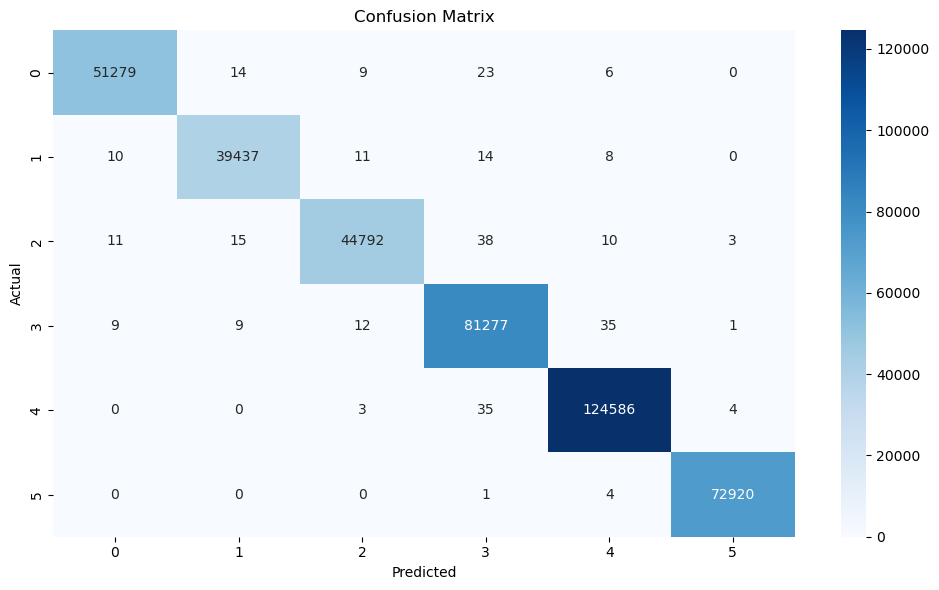

In [12]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str, target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# TRUSTEE

In [13]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

StartTime: 0.4089
EpochTime: 0.3494
BufferHealth: 0.1131
BufferProgress: 0.0236
Length: 0.0210
PlaybackProgress: 0.0123
RelativeTime: 0.0122
BytesSent0: 0.0099
PacketsSent: 0.0092
BytesSent: 0.0065
PacketsSent0: 0.0057
PacketsReceived: 0.0040
PacketsReceived0: 0.0040
CollectData: 0.0039
BytesReceived: 0.0037
Buffering: 0.0030
BytesReceived0: 0.0023
PacketsReceived25: 0.0013
BytesReceived25: 0.0012
UnlabelledQuality: 0.0011


In [15]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
# trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)

print("Fidelity to original model:")
print(classification_report(y_pred, dt_y_pred))

print("Accuracy vs. true labels:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9999823585145181
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 348243 points from training dataset with (1160812, 1160812) entries
Student model 0-0 trained with depth 18 and 219 leaves:
Student model score: 0.9993492261701385
Student model 0-0 fidelity: 0.9993492261701385
########## Inner-loop Iteration 1/2 ##########
Sampling 348243 points from training dataset with (1265285, 1265285) entries
Student model 0-1 trained with depth 18 and 218 leaves:
Student model score: 0.9996309592110774
Student model 0-1 fidelity: 0.9996309592110774
########## Outer-loop Iteration 1/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 348243 points from

/Users/stevenjiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Fidelity to original model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51309
           1       1.00      1.00      1.00     39475
           2       1.00      1.00      1.00     44827
           3       1.00      1.00      1.00     81388
           4       1.00      1.00      1.00    124649
           5       1.00      1.00      1.00     72928

    accuracy                           1.00    414576
   macro avg       1.00      1.00      1.00    414576
weighted avg       1.00      1.00      1.00    414576

Accuracy vs. true labels:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51331
           1       1.00      1.00      1.00     39480
           2       1.00      1.00      1.00     44869
           3       1.00      1.00      1.00     81343
           4       1.00      1.00      1.00    124628
           5       1.00      1.00      1.00     72925

    accuracy           

In [ ]:
OUTPUT_PATH = "out"
REPORT_PATH = f"{OUTPUT_PATH}/report/trust_report.obj"

if os.path.exists(REPORT_PATH):
    print(f"Loading trust report from {REPORT_PATH}...")
    trust_report = TrustReport.load(REPORT_PATH)
    print("Done!")
else:
    trust_report = TrustReport(
        blackbox=clf,
        X=X,
        y=y,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        max_iter=5,
        num_pruning_iter=5,
        train_size=0.7,
        trustee_num_iter=10,
        trustee_num_stability_iter=5,
        trustee_sample_size=0.3,
        analyze_branches=True,
        analyze_stability=True,
        top_k=10,
        verbose=True,
        class_names=list(le.classes_),
        feature_names=list(X.columns),
        is_classify=True,
    )

print(trust_report)
# trust_report.save(OUTPUT_PATH)

# AQUA

In [16]:
concept_dict = {
    'Rebuffering': ['cum_rebuf'],
    'Latency': ['min_rtt', 'rtt'],
    'Network': ['cwnd', 'in_flight', 'delivery_rate'],
    'VideoQuality': ['size'],
    'Buffer': ['buffer'],
    'ClientEvent': ['event'],
}

for concept, features in concept_dict.items():
    concept_dict[concept] = [f for f in features if f in X.columns]

In [17]:
def make_concept_features(X, concept_dict, agg='mean'):
    X_concepts = pd.DataFrame(index=X.index)
    for concept, cols in concept_dict.items():
        valid_cols = [col for col in cols if col in X.columns]
        if not valid_cols:
            continue
        if agg == 'mean':
            X_concepts[concept] = X[valid_cols].mean(axis=1)
        elif agg == 'max':
            X_concepts[concept] = X[valid_cols].max(axis=1)
        elif agg == 'sum':
            X_concepts[concept] = X[valid_cols].sum(axis=1)
    return X_concepts

X_test_concepts = make_concept_features(X_test, concept_dict)

In [18]:
print(X_test_concepts)

Empty DataFrame
Columns: []
Index: [1872714, 1539236, 915030, 1997594, 33012, 1245693, 273519, 575021, 1430335, 1419258, 197910, 1324867, 1320613, 411999, 1614882, 1024871, 2040122, 196413, 1925331, 1437512, 1631206, 319533, 1999438, 271334, 591957, 1885065, 1440499, 269103, 1164152, 1742719, 765143, 1276036, 600157, 299755, 1303249, 1400302, 177089, 264697, 1370815, 1221242, 2090798, 1579952, 125657, 690811, 294966, 577137, 1720230, 2060435, 1619736, 329009, 238237, 1231603, 1945290, 1153999, 1523488, 275749, 863470, 1976610, 1026609, 1141924, 1727654, 1404879, 1055436, 353833, 582074, 1026653, 2018601, 360403, 1752996, 1682283, 1961935, 1495994, 255668, 1578093, 1215392, 2003741, 1423341, 1575202, 638578, 682032, 1872004, 1705992, 1914267, 1008367, 1625928, 1758069, 1511796, 925306, 1323298, 1303149, 157463, 332107, 122089, 1188605, 1756412, 407065, 141204, 1421610, 1633854, 609278, ...]

[414576 rows x 0 columns]


In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a small decision tree on concept features
surrogate = DecisionTreeClassifier(max_depth=3, random_state=0)
surrogate.fit(X_test_concepts, y_test)

# Visualize the surrogate tree
plt.figure(figsize=(40, 24))
plot_tree(surrogate, 
          feature_names=X_test_concepts.columns, 
          filled=True, 
          class_names=[str(cls) for cls in sorted(y_test.unique())])
plt.title("Concept-Based Surrogate Tree")
plt.show()

ValueError: at least one array or dtype is required

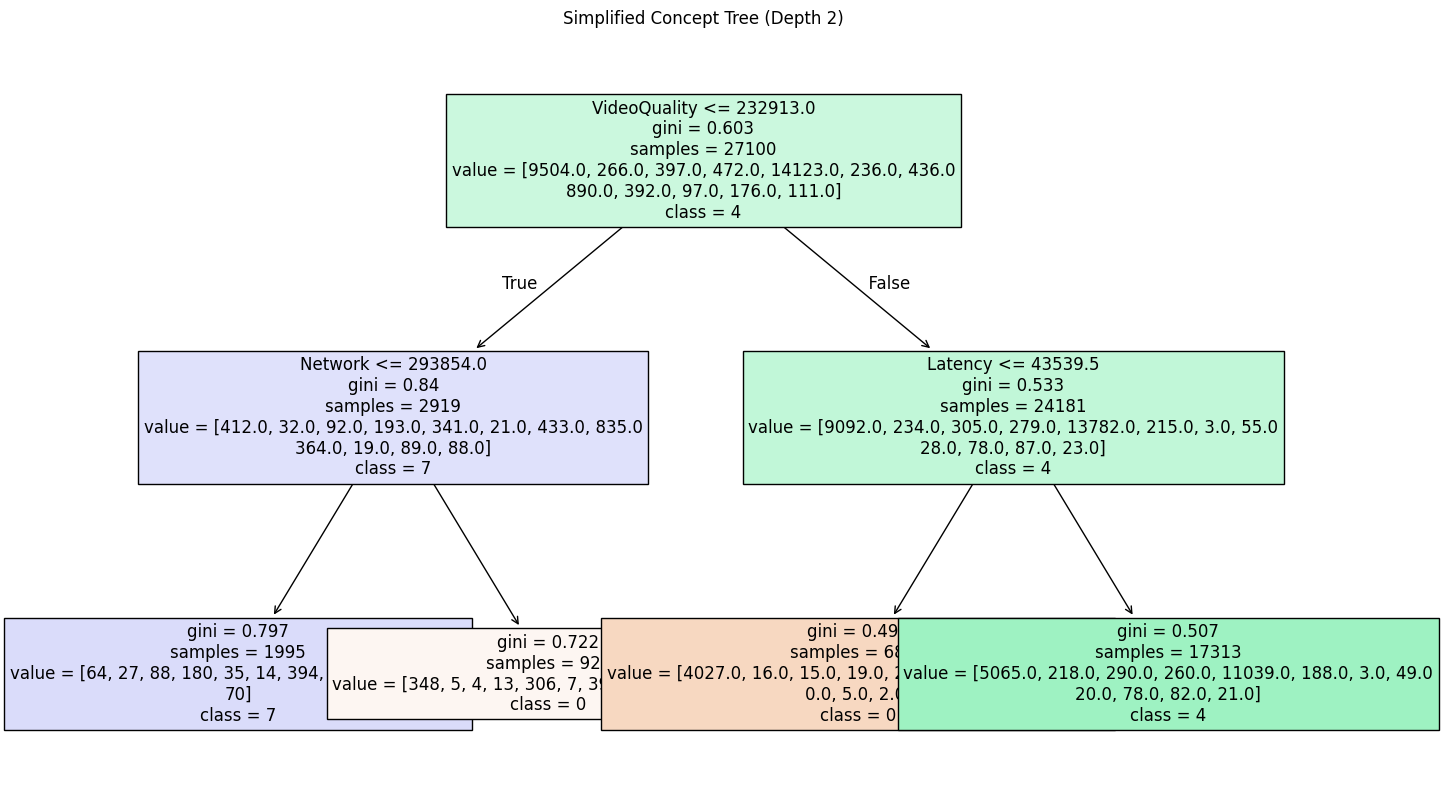

In [17]:
simpler_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
simpler_tree.fit(X_test_concepts, y_test)

plt.figure(figsize=(16, 10))
plot_tree(
    simpler_tree,
    feature_names=X_test_concepts.columns,
    filled=True,
    class_names=[str(cls) for cls in sorted(y_test.unique())],
    fontsize=12
)
plt.title("Simplified Concept Tree (Depth 2)")
plt.show()

ExactExplainer explainer: 1001it [00:25, 23.83it/s]                             
/var/folders/d9/210kwmkj07x7qlhkkmmnw4z80000gn/T/ipykernel_12939/141469809.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)


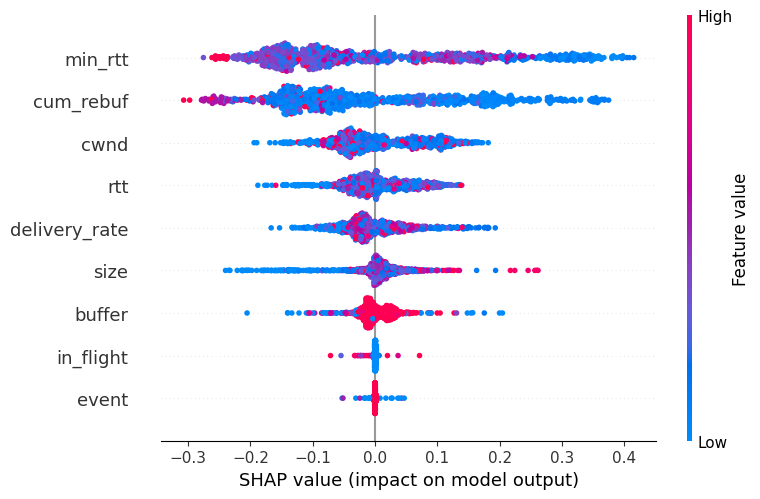

In [47]:
import shap

# Sample and DataFrame
X_sample = X_train[:1000]
X_sample_df = pd.DataFrame(X_sample, columns=[
    'size', 'cwnd', 'in_flight', 'min_rtt', 'rtt',
    'delivery_rate', 'event', 'buffer', 'cum_rebuf'
])

# Create SHAP explainer
explainer = shap.Explainer(clf.predict_proba, X_sample_df)
shap_values = explainer(X_sample_df)

# Summary plot for class index 0
shap.summary_plot(shap_values.values[:, :, 0], X_sample_df)